In [32]:
# !pip install -q transformers datasets accelerate peft bitsandbytes sentencepiece wandb trl

In [33]:
# from huggingface_hub import login
# login()

# گام اول: تولید داده مصنوعی در حوزه پزشکی

In [34]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer

# تبدیل داده‌های symptom-diagnosis به فرمت multiple-choice

In [ ]:
def convert_to_multiple_choice(data):
    mc_data = []
    for item in data:
        symptom = item['symptom']
        correct_diagnosis = item['diagnosis']
        # گزینه‌های نادرست (برای ساده‌سازی، به‌صورت دستی انتخاب شده‌اند)
        all_diagnoses = [d['diagnosis'] for d in data]
        incorrect_options = [d for d in all_diagnoses if d != correct_diagnosis]
        np.random.shuffle(incorrect_options)
        options = [correct_diagnosis] + incorrect_options[:3]  # 1 درست + 3 نادرست
        np.random.shuffle(options)  # مخلوط کردن گزینه‌ها
        answer = str(options.index(correct_diagnosis) + 1)  # شماره گزینه درست (1-4)
        mc_item = {
            "question": f"با توجه به علائم زیر، تشخیص درست چیست؟\n{symptom}",
            "options": options,
            "answer": answer
        }
        mc_data.append(mc_item)
    return mc_data

# داده آموزش

In [36]:
medical_data = [
  {
    "symptom": "مردی ۵۰ ساله با کاهش ناگهانی بینایی در چشم راست و بدون درد، با نوار چشم‌سنجی حاکی از 'بتور جریان خون شبکه' مراجعه کرده است.",
    "diagnosis": "انسداد شریان مرکزی شبکه"
  },
  {
    "symptom": "زنی ۶۰ ساله با سابقه دیابت و فشار خون بالا، با درد شدید در ناحیه شکم و تهوع مراجعه کرده است.",
    "diagnosis": "آنوریسم آئورت شکمی"
  },
  {
    "symptom": "کودکی ۵ ساله با تب بالا، سرفه خشک و تنگی نفس مراجعه کرده است.",
    "diagnosis": "پنومونی"
  },
  {
    "symptom": "مردی ۴۰ ساله با درد شدید در ناحیه کمر و مشکل در ادرار کردن مراجعه کرده است.",
    "diagnosis": "سنگ کلیه"
  },
  {
    "symptom": "زنی ۳۰ ساله با خستگی مزمن، کاهش وزن و تعریق شبانه مراجعه کرده است.",
    "diagnosis": "هیپرتیروئیدی"
  },
  {
    "symptom": "مردی ۶۵ ساله با درد قفسه سینه که به بازوی چپ منتشر می‌شود و تنگی نفس مراجعه کرده است.",
    "diagnosis": "سکته قلبی"
  },
  {
    "symptom": "زنی ۴۵ ساله با سردرد شدید، تهوع و حساسیت به نور مراجعه کرده است.",
    "diagnosis": "میگرن"
  },
  {
    "symptom": "کودکی ۸ ساله با سرفه مداوم، خس‌خس سینه و تنگی نفس شبانه مراجعه کرده است.",
    "diagnosis": "آسم"
  },
  {
    "symptom": "مردی ۳۵ ساله با زردی پوست، درد در ناحیه بالای شکم و ادرار تیره مراجعه کرده است.",
    "diagnosis": "هپاتیت"
  },
  {
    "symptom": "زنی ۵۵ ساله با تورم در پاها، خستگی و تنگی نفس هنگام فعالیت مراجعه کرده است.",
    "diagnosis": "نارسایی قلبی"
  },
  {
    "symptom": "مردی ۴۸ ساله با تشنج ناگهانی و از دست دادن هوشیاری مراجعه کرده است.",
    "diagnosis": "صرع"
  },
  {
    "symptom": "زنی ۳۸ ساله با درد شدید در ناحیه پایین شکم و خونریزی غیرطبیعی مراجعه کرده است.",
    "diagnosis": "بارداری خارج رحمی"
  },
  {
    "symptom": "کودکی ۱۰ ساله با تب، گلودرد و لکه‌های سفید روی لوزه‌ها مراجعه کرده است.",
    "diagnosis": "عفونت استرپتوکوکی"
  },
  {
    "symptom": "مردی ۷۰ ساله با کاهش حافظه، گیجی و مشکل در یافتن کلمات مراجعه کرده است.",
    "diagnosis": "آلزایمر"
  },
  {
    "symptom": "زنی ۲۵ ساله با درد هنگام ادرار و تکرر ادرار مراجعه کرده است.",
    "diagnosis": "عفونت ادراری"
  },
  {
    "symptom": "مردی ۵۲ ساله با سرگیجه، تهوع و عدم تعادل هنگام راه رفتن مراجعه کرده است.",
    "diagnosis": "سکته مغزی"
  },
  {
    "symptom": "زنی ۴۲ ساله با درد مفاصل، خستگی و بثورات پوستی روی صورت مراجعه کرده است.",
    "diagnosis": "لوپوس"
  },
  {
    "symptom": "کودکی ۶ ساله با اسهال شدید، تب و استفراغ مراجعه کرده است.",
    "diagnosis": "گاستروانتریت"
  },
  {
    "symptom": "مردی ۳۳ ساله با سرفه خونی و کاهش وزن مراجعه کرده است.",
    "diagnosis": "سل"
  },
  {
    "symptom": "زنی ۵۰ ساله با تپش قلب، اضطراب و لرزش دست‌ها مراجعه کرده است.",
    "diagnosis": "پرکاری تیروئید"
  },
  {
    "symptom": "مردی ۶۰ ساله با درد شدید در شانه راست و محدودیت حرکتی مراجعه کرده است.",
    "diagnosis": "آرتریت روماتوئید"
  },
  {
    "symptom": "زنی ۳۵ ساله با خونریزی شدید قاعدگی و کم‌خونی مراجعه کرده است.",
    "diagnosis": "فیبروم رحمی"
  },
  {
    "symptom": "کودکی ۴ ساله با تب بالا و تشنج مراجعه کرده است.",
    "diagnosis": "تب تشنجی"
  },
  {
    "symptom": "مردی ۴۵ ساله با درد در ناحیه بالای شکم و نفخ پس از غذا خوردن مراجعه کرده است.",
    "diagnosis": "زخم معده"
  },
  {
    "symptom": "زنی ۲۸ ساله با خارش شدید پوست و کهیر مراجعه کرده است.",
    "diagnosis": "آلرژی"
  },
  {
    "symptom": "مردی ۵۸ ساله با تنگی نفس، سرفه مزمن و سابقه سیگار کشیدن مراجعه کرده است.",
    "diagnosis": "بیماری مزمن انسدادی ریه (COPD)"
  },
  {
    "symptom": "زنی ۴۸ ساله با گرگرفتگی، تعریق شبانه و بی‌خوابی مراجعه کرده است.",
    "diagnosis": "یائسگی"
  },
  {
    "symptom": "کودکی ۷ ساله با درد گوش و تب مراجعه کرده است.",
    "diagnosis": "عفونت گوش میانی"
  },
  {
    "symptom": "مردی ۳۷ ساله با درد شدید در ناحیه پایین کمر پس از بلند کردن جسم سنگین مراجعه کرده است.",
    "diagnosis": "فتق دیسک کمر"
  },
  {
    "symptom": "زنی ۶۵ ساله با سرفه مزمن، کاهش وزن و درد قفسه سینه مراجعه کرده است.",
    "diagnosis": "سرطان ریه"
  },
  {
    "symptom": "مردی ۴۲ ساله با فشار خون بالا، سردرد و تاری دید مراجعه کرده است.",
    "diagnosis": "بحران فشار خون"
  },
  {
    "symptom": "زنی ۳۳ ساله با تشنگی شدید، تکرر ادرار و خستگی مراجعه کرده است.",
    "diagnosis": "دیابت نوع ۲"
  },
  {
    "symptom": "کودکی ۹ ساله با درد شکم، تهوع و مدفوع چرب مراجعه کرده است.",
    "diagnosis": "سلیاک"
  },
  {
    "symptom": "مردی ۵۵ ساله با درد در ناحیه کبد و خستگی مزمن مراجعه کرده است.",
    "diagnosis": "سیروز کبدی"
  },
  {
    "symptom": "زنی ۴۰ ساله با درد قفسه سینه هنگام فعالیت و تنگی نفس مراجعه کرده است.",
    "diagnosis": "آنژین صدری"
  },
  {
    "symptom": "مردی ۶۸ ساله با ضعف عضلانی، مشکل در بلع و دوبینی مراجعه کرده است.",
    "diagnosis": "میاستنی گراویس"
  },
  {
    "symptom": "زنی ۲۷ ساله با تب، درد عضلانی و بثورات پوستی پس از سفر به منطقه گرمسیری مراجعه کرده است.",
    "diagnosis": "مالاریا"
  },
  {
    "symptom": "کودکی ۳ ساله با تنگی نفس ناگهانی و صدای خس‌خس هنگام تنفس مراجعه کرده است.",
    "diagnosis": "کروپ"
  },
  {
    "symptom": "مردی ۴۷ ساله با درد شدید در ناحیه پشت و تب مراجعه کرده است.",
    "diagnosis": "پیلونفریت"
  },
  {
    "symptom": "زنی ۵۳ ساله با کاهش شنوایی تدریجی و وزوز گوش مراجعه کرده است.",
    "diagnosis": "ناشنوایی عصبی"
  },
  {
    "symptom": "مردی ۳۹ ساله با سرفه خشک، تب و خستگی پس از تماس با پرندگان مراجعه کرده است.",
    "diagnosis": "پسیتاکوز"
  },
  {
    "symptom": "زنی ۴۴ ساله با درد مزمن شکم، اسهال و یبوست متناوب مراجعه کرده است.",
    "diagnosis": "سندرم روده تحریک‌پذیر"
  },
  {
    "symptom": "کودکی ۱۱ ساله با تب، درد مفاصل و بثورات پوستی مراجعه کرده است.",
    "diagnosis": "تب روماتیسمی"
  },
  {
    "symptom": "مردی ۶۲ ساله با تنگی نفس شدید و سرفه خونی مراجعه کرده است.",
    "diagnosis": "آمبولی ریه"
  },
  {
    "symptom": "زنی ۳۶ ساله با درد شدید در ناحیه راست شکم و تب مراجعه کرده است.",
    "diagnosis": "آپاندیسیت"
  },
  {
    "symptom": "مردی ۵۱ ساله با ضعف در دست‌ها و پاها و گزگز اندام‌ها مراجعه کرده است.",
    "diagnosis": "مولتیپل اسکلروزیس"
  },
  {
    "symptom": "زنی ۲۹ ساله با تورم صورت، خستگی و افزایش وزن مراجعه کرده است.",
    "diagnosis": "کم‌کاری تیروئید"
  },
  {
    "symptom": "کودکی ۲ ساله با تب بالا، استفراغ و خواب‌آلودگی مراجعه کرده است.",
    "diagnosis": "مننژیت"
  },
  {
    "symptom": "مردی ۴۳ ساله با درد شدید در ناحیه بالای شکم که به پشت منتشر می‌شود مراجعه کرده است.",
    "diagnosis": "پانکراتیت"
  },
  {
    "symptom": "زنی ۵۷ ساله با سرگیجه، تعریق و تپش قلب مراجعه کرده است.",
    "diagnosis": "هیپوگلیسمی"
  },
  {
    "symptom": "مردی ۶۷ ساله با مشکل در تکلم و ضعف در سمت راست بدن مراجعه کرده است.",
    "diagnosis": "سکته مغزی ایسکمیک"
  },
  {
    "symptom": "زنی ۳۴ ساله با خارش شدید، زردی پوست و درد شکم مراجعه کرده است.",
    "diagnosis": "سنگ کیسه صفرا"
  },
  {
    "symptom": "کودکی ۱۲ ساله با درد شدید زانو و تب پس از عفونت گلو مراجعه کرده است.",
    "diagnosis": "آرتریت روماتیسمی"
  },
  {
    "symptom": "مردی ۴۹ ساله با تنگی نفس، تورم پاها و خستگی مراجعه کرده است.",
    "diagnosis": "کاردیومیوپاتی"
  },
  {
    "symptom": "زنی ۴۱ ساله با سردرد مزمن و فشار در ناحیه پشت چشم‌ها مراجعه کرده است.",
    "diagnosis": "سینوزیت"
  },
  {
    "symptom": "مردی ۵۴ ساله با سرفه مزمن و خلط خونی مراجعه کرده است.",
    "diagnosis": "برونشکتازی"
  },
  {
    "symptom": "زنی ۳۱ ساله با تپش قلب، کاهش وزن و بی‌قراری مراجعه کرده است.",
    "diagnosis": "بیماری گریوز"
  },
  {
    "symptom": "کودکی ۵ ساله با تب، تورم غدد لنفاوی و گلودرد مراجعه کرده است.",
    "diagnosis": "مونونوکلئوز"
  },
  {
    "symptom": "مردی ۶۳ ساله با درد شدید قفسه سینه و تنگی نفس ناگهانی مراجعه کرده است.",
    "diagnosis": "پنوموتوراکس"
  },
  {
    "symptom": "زنی ۴۶ ساله با خونریزی گوارشی، مدفوع سیاه و ضعف مراجعه کرده است.",
    "diagnosis": "خونریزی معده"
  },
  {
    "symptom": "مردی ۳۸ ساله با تب، لرز و درد پهلو مراجعه کرده است.",
    "diagnosis": "عفونت کلیه"
  },
  {
    "symptom": "زنی ۵۹ ساله با درد مفاصل، خشکی صبحگاهی و خستگی مراجعه کرده است.",
    "diagnosis": "آرتروز"
  },
  {
    "symptom": "کودکی ۷ ساله با تب، بثورات پوستی و قرمزی چشم‌ها مراجعه کرده است.",
    "diagnosis": "بیماری کاوازاکی"
  },
  {
    "symptom": "مردی ۴۴ ساله با درد شدید شکم، تهوع و استفراغ مراجعه کرده است.",
    "diagnosis": "انسداد روده"
  },
  {
    "symptom": "زنی ۳۲ ساله با تنگی نفس، سرفه خشک و خستگی مزمن مراجعه کرده است.",
    "diagnosis": "سارکوئیدوز"
  },
  {
    "symptom": "مردی ۶۱ ساله با ضعف عمومی، تشنگی و کاهش وزن مراجعه کرده است.",
    "diagnosis": "دیابت نوع ۱"
  },
  {
    "symptom": "زنی ۴۷ ساله با درد شدید در ناحیه بالای شکم و سوء هاضمه مراجعه کرده است.",
    "diagnosis": "گاستریت"
  },
  {
    "symptom": "کودکی ۶ ساله با تب بالا، سرفه و گوش‌درد مراجعه کرده است.",
    "diagnosis": "اوتیت مدیا"
  },
  {
    "symptom": "مردی ۵۶ ساله با تنگی نفس، سرفه مزمن و کاهش وزن مراجعه کرده است.",
    "diagnosis": "فیبروز ریوی"
  },
  {
    "symptom": "زنی ۳۹ ساله با سردرد شدید، تهوع و تاری دید مراجعه کرده است.",
    "diagnosis": "فشار خون بالای مغزی"
  },
  {
    "symptom": "مردی ۴۵ ساله با درد در ناحیه قفسه سینه و تنگی نفس هنگام استراحت مراجعه کرده است.",
    "diagnosis": "پریکاردیت"
  },
  {
    "symptom": "زنی ۵۲ ساله با خستگی، ضعف و رنگ‌پریدگی مراجعه کرده است.",
    "diagnosis": "کم‌خونی"
  },
  {
    "symptom": "کودکی ۸ ساله با تب، درد شکم و استفراغ مراجعه کرده است.",
    "diagnosis": "گاستروانتریت ویروسی"
  },
  {
    "symptom": "مردی ۶۴ ساله با کاهش وزن، درد شکم و یبوست مزمن مراجعه کرده است.",
    "diagnosis": "سرطان روده بزرگ"
  },
  {
    "symptom": "زنی ۳۵ ساله با تورم دردناک غدد لنفاوی و تب مراجعه کرده است.",
    "diagnosis": "لنفادنیت"
  },
  {
    "symptom": "مردی ۴۸ ساله با سرگیجه، سردرد و افزایش فشار خون مراجعه کرده است.",
    "diagnosis": "فئوکروموسیتوم"
  },
  {
    "symptom": "زنی ۴۳ ساله با درد شدید در ناحیه پایین شکم و تب مراجعه کرده است.",
    "diagnosis": "دیورتیکولیت"
  },
  {
    "symptom": "کودکی ۴ ساله با تب، بثورات پوستی و التهاب ملتحمه مراجعه کرده است.",
    "diagnosis": "سرخک"
  },
  {
    "symptom": "مردی ۵۷ ساله با تنگی نفس، تورم پاها و سرفه شبانه مراجعه کرده است.",
    "diagnosis": "ادم ریوی"
  },
  {
    "symptom": "زنی ۳۷ ساله با درد مفاصل، تب و خستگی مزمن مراجعه کرده است.",
    "diagnosis": "بیماری بهجت"
  },
  {
    "symptom": "مردی ۶۰ ساله با کاهش شنوایی، سرگیجه و صدای زنگ در گوش مراجعه کرده است.",
    "diagnosis": "بیماری منییر"
  },
  {
    "symptom": "زنی ۴۹ ساله با درد قفسه سینه، تنگی نفس و تپش قلب مراجعه کرده است.",
    "diagnosis": "تاکی‌کاردی فوق بطنی"
  },
  {
    "symptom": "کودکی ۹ ساله با تب، سرفه و تنگی نفس پس از بازی در فضای باز مراجعه کرده است.",
    "diagnosis": "آلرژی فصلی"
  },
  {
    "symptom": "مردی ۴۱ ساله با درد شدید در ناحیه پشت و خون در ادرار مراجعه کرده است.",
    "diagnosis": "نفرولیتیازیس"
  },
  {
    "symptom": "زنی ۵۴ ساله با خستگی، کاهش اشتها و درد شکم مراجعه کرده است.",
    "diagnosis": "سرطان معده"
  },
  {
    "symptom": "مردی ۳۶ ساله با تب، لرز و درد عضلانی پس از گزش حشره مراجعه کرده است.",
    "diagnosis": "تب دنگی"
  },
  {
    "symptom": "زنی ۴۵ ساله با سردرد، تهوع و ضعف در سمت چپ بدن مراجعه کرده است.",
    "diagnosis": "میگرن همی‌پلژیک"
  },
  {
    "symptom": "کودکی ۳ ساله با تب بالا، گریه بی‌وقفه و سفتی گردن مراجعه کرده است.",
    "diagnosis": "مننژیت باکتریایی"
  },
  {
    "symptom": "مردی ۵۳ ساله با تنگی نفس، درد قفسه سینه و سرفه خشک مراجعه کرده است.",
    "diagnosis": "پلوریت"
  },
  {
    "symptom": "زنی ۳۸ ساله با تشنگی شدید، خشکی دهان و کاهش وزن مراجعه کرده است.",
    "diagnosis": "دیابت بی‌مزه"
  },
  {
    "symptom": "مردی ۶۶ ساله با درد مزمن کمر، ضعف پاها و بی‌حسی مراجعه کرده است.",
    "diagnosis": "تنگی کانال نخاعی"
  },
  {
    "symptom": "زنی ۴۲ ساله با تورم دردناک مچ پا و تب مراجعه کرده است.",
    "diagnosis": "نقرس"
  },
  {
    "symptom": "کودکی ۱۰ ساله با تب، سرفه شدید و تنگی نفس مراجعه کرده است.",
    "diagnosis": "سیاه‌سرفه"
  },
  {
    "symptom": "مردی ۴۹ ساله با درد شدید شکم، تب و زردی پوست مراجعه کرده است.",
    "diagnosis": "کوله‌سیستیت"
  },
  {
    "symptom": "زنی ۵۱ ساله با خستگی مزمن، افسردگی و افزایش وزن مراجعه کرده است.",
    "diagnosis": "هیپوتیروئیدی"
  },
  {
    "symptom": "مردی ۵۵ ساله با سرفه مزمن، خلط خونی و تنگی نفس مراجعه کرده است.",
    "diagnosis": "سرطان برونش"
  },
  {
    "symptom": "زنی ۳۳ ساله با درد شدید در ناحیه پایین شکم و ترشحات غیرطبیعی مراجعه کرده است.",
    "diagnosis": "بیماری التهابی لگن"
  },
  {
    "symptom": "کودکی ۶ ساله با تب، بثورات پوستی و تورم دست‌ها و پاها مراجعه کرده است.",
    "diagnosis": "بیماری دست، پا و دهان"
  },
  {
    "symptom": "مردی ۴۷ ساله با سردرد شدید، تب و گیجی مراجعه کرده است.",
    "diagnosis": "آنسفالیت"
  }
]


# تبدیل و تست کردن

In [ ]:
medical_data = convert_to_multiple_choice(medical_data)


with open('medical_training_data.json', 'w', encoding='utf-8') as f:
    json.dump(medical_data, f, ensure_ascii=False, indent=2)

print(f"تعداد نمونه‌های داده آموزشی: {len(medical_data)}")
print("نمونه‌های داده آموزشی:")
for i in range(5):
    print(f"\nنمونه {i+1}:")
    print(f"سوال: {medical_data[i]['question']}")
    print(f"گزینه‌ها: {', '.join(medical_data[i]['options'])}")
    print(f"پاسخ: {medical_data[i]['answer']}")

تعداد نمونه‌های داده آموزشی: 99
نمونه‌های داده آموزشی:

نمونه 1:
سوال: با توجه به علائم زیر، تشخیص درست چیست؟
مردی ۵۰ ساله با کاهش ناگهانی بینایی در چشم راست و بدون درد، با نوار چشم‌سنجی حاکی از 'بتور جریان خون شبکه' مراجعه کرده است.
گزینه‌ها: سرطان برونش, انسداد روده, انسداد شریان مرکزی شبکه, سندرم روده تحریک‌پذیر
پاسخ: 3

نمونه 2:
سوال: با توجه به علائم زیر، تشخیص درست چیست؟
زنی ۶۰ ساله با سابقه دیابت و فشار خون بالا، با درد شدید در ناحیه شکم و تهوع مراجعه کرده است.
گزینه‌ها: بیماری منییر, پیلونفریت, گاستریت, آنوریسم آئورت شکمی
پاسخ: 4

نمونه 3:
سوال: با توجه به علائم زیر، تشخیص درست چیست؟
کودکی ۵ ساله با تب بالا، سرفه خشک و تنگی نفس مراجعه کرده است.
گزینه‌ها: عفونت گوش میانی, پنومونی, دیابت نوع ۱, پنوموتوراکس
پاسخ: 2

نمونه 4:
سوال: با توجه به علائم زیر، تشخیص درست چیست؟
مردی ۴۰ ساله با درد شدید در ناحیه کمر و مشکل در ادرار کردن مراجعه کرده است.
گزینه‌ها: سکته قلبی, خونریزی معده, سنگ کلیه, آنژین صدری
پاسخ: 3

نمونه 5:
سوال: با توجه به علائم زیر، تشخیص درست چیست؟
زنی ۳۰ ساله با خستگی

# داده تست

In [38]:
evaluation_data = [
    {
      "question": "کدام یک از موارد زیر برای پیشگیری از سرخک استفاده می‌شود؟",
      "options": [
        "واکسن MMR",
        "واکسن DPT",
        "واکسن هپاتیت B",
        "واکسن آنفولانزا"
      ],
      "answer": "واکسن MMR"
    },
    {
      "question": "شایع‌ترین عارضه آبله‌مرغان چیست؟",
      "options": ["تب", "خارش پوست", "درد عضلانی", "تهوع"],
      "answer": "خارش پوست"
    },
    {
      "question": "کدام یک از موارد زیر از علائم شایع دیابت نوع 2 است؟",
      "options": ["تشنگی بیش از حد", "خستگی", "کاهش وزن ناگهانی", "همه موارد"],
      "answer": "همه موارد"
    },
    {
      "question": "کدام اندام مسئول پمپاژ خون در بدن است؟",
      "options": ["کبد", "قلب", "ریه", "کلیه"],
      "answer": "قلب"
    },
    {
      "question": "داروی پاراستامول برای چه چیزی استفاده می‌شود؟",
      "options": ["کاهش تب", "درمان فشار خون", "درمان دیابت", "ضد التهاب"],
      "answer": "کاهش تب"
    },
    {
      "question": "بهترین روش شستشوی دست‌ها برای پیشگیری از بیماری‌ها چیست؟",
      "options": ["آب سرد", "صابون و آب گرم", "الکل", "دستمال مرطوب"],
      "answer": "صابون و آب گرم"
    },
    {
      "question": "کدام یک از موارد زیر منبع خوبی برای کلسیم است؟",
      "options": ["شیر", "موز", "سیب", "برنج"],
      "answer": "شیر"
    },
    {
      "question": "کدام یک از موارد زیر از علائم اضطراب است؟",
      "options": ["تپش قلب", "افزایش انرژی", "خواب عمیق", "تمرکز بالا"],
      "answer": "تپش قلب"
    },
    {
      "question": "بیماری سل معمولاً کدام اندام را درگیر می‌کند؟",
      "options": ["ریه", "کبد", "قلب", "معده"],
      "answer": "ریه"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان سرماخوردگی توصیه نمی‌شود؟",
      "options": ["استراحت", "مایعات گرم", "آنتی‌بیوتیک", "ویتامین C"],
      "answer": "آنتی‌بیوتیک"
    },
    {
      "question": "کدام بیماری با فشار خون بالا مرتبط است؟",
      "options": ["سکته مغزی", "هپاتیت", "آسم", "سرماخوردگی"],
      "answer": "سکته مغزی"
    },
    {
      "question": "بزرگ‌ترین استخوان بدن کدام است؟",
      "options": ["استخوان ران", "جمجمه", "ستون فقرات", "استخوان بازو"],
      "answer": "استخوان ران"
    },
    {
      "question": "کدام دارو برای کاهش کلسترول استفاده می‌شود؟",
      "options": ["استاتین", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "استاتین"
    },
    {
      "question": "کدام یک از موارد زیر از راه‌های انتقال هپاتیت B است؟",
      "options": ["خون آلوده", "هوای آلوده", "غذای ناسالم", "آب آلوده"],
      "answer": "خون آلوده"
    },
    {
      "question": "کدام ماده غذایی برای سلامت قلب مفید است؟",
      "options": ["ماهی", "چیپس", "شیرینی", "گوشت قرمز"],
      "answer": "ماهی"
    },
    {
      "question": "کدام یک از موارد زیر نشانه افسردگی نیست؟",
      "options": ["بی‌خوابی", "احساس غم", "افزایش اشتها", "شادی بیش از حد"],
      "answer": "شادی بیش از حد"
    },
    {
      "question": "کدام بیماری با کمبود ویتامین D مرتبط است؟",
      "options": ["راشیتیسم", "آنفولانزا", "دیابت", "فشار خون"],
      "answer": "راشیتیسم"
    },
    {
      "question": "کدام اندام مسئول تصفیه خون است؟",
      "options": ["کلیه", "کبد", "طحال", "ریه"],
      "answer": "کلیه"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان آسم استفاده می‌شود؟",
      "options": ["اسپری سالبوتامول", "آسپرین", "پاراستامول", "آنتی‌بیوتیک"],
      "answer": "اسپری سالبوتامول"
    },
    {
      "question": "کدام بیماری از طریق نیش پشه منتقل می‌شود؟",
      "options": ["مالاریا", "هپاتیت", "سل", "دیابت"],
      "answer": "مالاریا"
    },
    {
      "question": "مهم‌ترین علامت سکته قلبی چیست؟",
      "options": ["درد قفسه سینه", "سردرد", "تهوع", "تب"],
      "answer": "درد قفسه سینه"
    },
    {
      "question": "کدام یک از موارد زیر در بدن هورمون تولید می‌کند؟",
      "options": ["غدد درون‌ریز", "کبد", "معده", "ریه"],
      "answer": "غدد درون‌ریز"
    },
    {
      "question": "کدام ویتامین برای سلامت چشم مفید است؟",
      "options": ["ویتامین A", "ویتامین B", "ویتامین C", "ویتامین D"],
      "answer": "ویتامین A"
    },
    {
      "question": "کدام یک از موارد زیر نشانه استرس شدید است؟",
      "options": ["تعریق", "خواب‌آلودگی", "افزایش وزن", "همه موارد"],
      "answer": "تعریق"
    },
    {
      "question": "کدام بیماری با سیگار کشیدن مرتبط است؟",
      "options": ["سرطان ریه", "دیابت", "هپاتیت", "آرتریت"],
      "answer": "سرطان ریه"
    },
    {
      "question": "کدام اندام اکسیژن را به خون منتقل می‌کند؟",
      "options": ["ریه", "قلب", "کبد", "کلیه"],
      "answer": "ریه"
    },
    {
      "question": "کدام یک از موارد زیر برای کاهش التهاب استفاده می‌شود؟",
      "options": ["ایبوپروفن", "پنی‌سیلین", "متفورمین", "واکسن"],
      "answer": "ایبوپروفن"
    },
    {
      "question": "کدام یک از موارد زیر برای پیشگیری از پوکی استخوان مفید است؟",
      "options": ["کلسیم", "آهن", "پتاسیم", "سدیم"],
      "answer": "کلسیم"
    },
    {
      "question": "کدام بیماری با چاقی مرتبط است؟",
      "options": ["دیابت نوع 2", "سرماخوردگی", "سل", "مالاریا"],
      "answer": "دیابت نوع 2"
    },
    {
      "question": "کدام یک از موارد زیر بخشی از سیستم گوارش است؟",
      "options": ["معده", "قلب", "ریه", "مغز"],
      "answer": "معده"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان عفونت باکتریایی است؟",
      "options": ["آنتی‌بیوتیک", "ضد ویروس", "واکسن", "شیمی‌درمانی"],
      "answer": "آنتی‌بیوتیک"
    },
    {
      "question": "کدام ماده غذایی برای سلامت مغز مفید است؟",
      "options": ["گردو", "شکلات", "چیپس", "نوشابه"],
      "answer": "گردو"
    },
    {
      "question": "کدام یک از موارد زیر از علائم کم‌خونی است؟",
      "options": ["خستگی", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "خستگی"
    },
    {
      "question": "کدام بیماری با ویروس HIV مرتبط است؟",
      "options": ["ایدز", "مالاریا", "سل", "دیابت"],
      "answer": "ایدز"
    },
    {
      "question": "کدام اندام مسئول تنظیم قند خون است؟",
      "options": ["لوزالمعده", "کبد", "قلب", "ریه"],
      "answer": "لوزالمعده"
    },
    {
      "question": "کدام یک از موارد زیر برای کاهش درد مفاصل استفاده می‌شود؟",
      "options": ["دیکلوفناک", "پنی‌سیلین", "واکسن", "متفورمین"],
      "answer": "دیکلوفناک"
    },
    {
      "question": "کدام یک از موارد زیر برای سلامت پوست مفید است؟",
      "options": ["ویتامین E", "ویتامین B", "ویتامین K", "ویتامین D"],
      "answer": "ویتامین E"
    },
    {
      "question": "کدام بیماری از طریق آب آلوده منتقل می‌شود؟",
      "options": ["وبا", "سرطان", "آسم", "دیابت"],
      "answer": "وبا"
    },
    {
      "question": "کدام یک از موارد زیر نشانه فشار خون بالا نیست؟",
      "options": ["سردرد", "خونریزی بینی", "درد شکم", "تاری دید"],
      "answer": "درد شکم"
    },
    {
      "question": "کدام اندام مسئول تولید صفرا است؟",
      "options": ["کبد", "کلیه", "معده", "طحال"],
      "answer": "کبد"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان تب استفاده می‌شود؟",
      "options": ["پاراستامول", "آنتی‌بیوتیک", "واکسن", "شیمی‌درمانی"],
      "answer": "پاراستامول"
    },
    {
      "question": "کدام ماده غذایی برای کاهش کلسترول مفید است؟",
      "options": ["جو", "شکر", "نمک", "روغن حیوانی"],
      "answer": "جو"
    },
    {
      "question": "کدام یک از موارد زیر از علائم آلرژی است؟",
      "options": ["عطسه", "تب بالا", "درد عضلانی", "افزایش وزن"],
      "answer": "عطسه"
    },
    {
      "question": "کدام بیماری با کمبود آهن مرتبط است؟",
      "options": ["کم‌خونی", "فشار خون", "دیابت", "آسم"],
      "answer": "کم‌خونی"
    },
    {
      "question": "کدام اندام مسئول دفع مواد زائد از خون است؟",
      "options": ["کلیه", "قلب", "ریه", "معده"],
      "answer": "کلیه"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان سرفه استفاده می‌شود؟",
      "options": ["شربت دکسترومتورفان", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "شربت دکسترومتورفان"
    },
    {
      "question": "کدام یک از موارد زیر برای سلامت استخوان‌ها مفید است؟",
      "options": ["ویتامین D", "ویتامین B", "ویتامین C", "ویتامین E"],
      "answer": "ویتامین D"
    },
    {
      "question": "کدام بیماری با التهاب مفاصل مرتبط است؟",
      "options": ["آرتریت", "هپاتیت", "مالاریا", "دیابت"],
      "answer": "آرتریت"
    },
    {
      "question": "کدام اندام مسئول تنفس است؟",
      "options": ["ریه", "قلب", "کبد", "کلیه"],
      "answer": "ریه"
    },
    {
      "question": "کدام یک از موارد زیر برای کاهش فشار خون استفاده می‌شود؟",
      "options": ["لیزینوپریل", "پاراستامول", "پنی‌سیلین", "واکسن"],
      "answer": "لیزینوپریل"
    },
    {
      "question": "کدام ماده غذایی برای سلامت کبد مفید است؟",
      "options": ["قهوه", "الکل", "شکر", "چربی حیوانی"],
      "answer": "قهوه"
    },
    {
      "question": "کدام یک از موارد زیر از علائم عفونت ادراری است؟",
      "options": ["سوزش ادرار", "تب", "درد کمر", "همه موارد"],
      "answer": "همه موارد"
    },
    {
      "question": "کدام بیماری با ویروس آنفولانزا مرتبط است؟",
      "options": ["سرماخوردگی", "هپاتیت", "سل", "دیابت"],
      "answer": "سرماخوردگی"
    },
    {
      "question": "کدام اندام مسئول هضم غذا است؟",
      "options": ["معده", "قلب", "ریه", "مغز"],
      "answer": "معده"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان یبوست استفاده می‌شود؟",
      "options": ["ملین", "آنتی‌بیوتیک", "واکسن", "شیمی‌درمانی"],
      "answer": "ملین"
    },
    {
      "question": "کدام ماده غذایی برای سلامت قلب مفید است؟",
      "options": ["آووکادو", "شکلات", "چیپس", "نوشابه"],
      "answer": "آووکادو"
    },
    {
      "question": "کدام یک از موارد زیر از علائم میگرن است؟",
      "options": ["سردرد شدید", "تب", "درد عضلانی", "افزایش وزن"],
      "answer": "سردرد شدید"
    },
    {
      "question": "کدام بیماری با باکتری هلیکوباکتر پیلوری مرتبط است؟",
      "options": ["زخم معده", "مالاریا", "سل", "دیابت"],
      "answer": "زخم معده"
    },
    {
      "question": "کدام اندام مسئول تنظیم دمای بدن است؟",
      "options": ["هیپوتالاموس", "کبد", "قلب", "ریه"],
      "answer": "هیپوتالاموس"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان اسهال استفاده می‌شود؟",
      "options": ["او آر اس", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "او آر اس"
    },
    {
      "question": "کدام ماده غذایی برای کاهش التهاب مفید است؟",
      "options": ["زردچوبه", "شکر", "نمک", "روغن حیوانی"],
      "answer": "زردچوبه"
    },
    {
      "question": "کدام یک از موارد زیر از علائم سنگ کلیه است؟",
      "options": ["درد پهلو", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "درد پهلو"
    },
    {
      "question": "کدام بیماری با کمبود ویتامین C مرتبط است؟",
      "options": ["اسکوروی", "هپاتیت", "مالاریا", "دیابت"],
      "answer": "اسکوروی"
    },
    {
      "question": "کدام اندام مسئول انتقال پیام‌های عصبی است؟",
      "options": ["مغز", "قلب", "کبد", "کلیه"],
      "answer": "مغز"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان اضطراب استفاده می‌شود؟",
      "options": ["دیازپام", "پاراستامول", "پنی‌سیلین", "واکسن"],
      "answer": "دیازپام"
    },
    {
      "question": "کدام ماده غذایی برای سلامت مو مفید است؟",
      "options": ["بیوتین", "شکر", "نمک", "چربی حیوانی"],
      "answer": "بیوتین"
    },
    {
      "question": "کدام یک از موارد زیر از علائم آپاندیسیت است؟",
      "options": ["درد شکم", "تب", "درد مفاصل", "همه موارد"],
      "answer": "درد شکم"
    },
    {
      "question": "کدام بیماری با ویروس هپاتیت A مرتبط است؟",
      "options": ["التهاب کبد", "مالاریا", "سل", "دیابت"],
      "answer": "التهاب کبد"
    },
    {
      "question": "کدام اندام مسئول تولید گلبول‌های قرمز است؟",
      "options": ["مغز استخوان", "کبد", "قلب", "ریه"],
      "answer": "مغز استخوان"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان رفلاکس معده استفاده می‌شود؟",
      "options": ["امپرازول", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "امپرازول"
    },
    {
      "question": "کدام ماده غذایی برای کاهش فشار خون مفید است؟",
      "options": ["چغندر", "شکر", "نمک", "روغن حیوانی"],
      "answer": "چغندر"
    },
    {
      "question": "کدام یک از موارد زیر از علائم پارکینسون است؟",
      "options": ["لرزش دست", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "لرزش دست"
    },
    {
      "question": "کدام بیماری با ویروس تبخال مرتبط است؟",
      "options": ["هرپس", "هپاتیت", "مالاریا", "دیابت"],
      "answer": "هرپس"
    },
    {
      "question": "کدام اندام مسئول تنظیم تعادل بدن است؟",
      "options": ["مخچه", "کبد", "قلب", "ریه"],
      "answer": "مخچه"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان تشنج استفاده می‌شود؟",
      "options": ["والپروات", "پاراستامول", "پنی‌سیلین", "واکسن"],
      "answer": "والپروات"
    },
    {
      "question": "کدام ماده غذایی برای سلامت کلیه مفید است؟",
      "options": ["آب", "الکل", "شکر", "چربی حیوانی"],
      "answer": "آب"
    },
    {
      "question": "کدام یک از موارد زیر از علائم سکته مغزی است؟",
      "options": ["ضعف یک‌طرفه بدن", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "ضعف یک‌طرفه بدن"
    },
    {
      "question": "کدام بیماری با باکتری استرپتوکوک مرتبط است؟",
      "options": ["گلودرد چرکی", "مالاریا", "سل", "دیابت"],
      "answer": "گلودرد چرکی"
    },
    {
      "question": "کدام اندام مسئول تولید انسولین است؟",
      "options": ["لوزالمعده", "کبد", "قلب", "ریه"],
      "answer": "لوزالمعده"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان آلرژی استفاده می‌شود؟",
      "options": ["آنتی‌هیستامین", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "آنتی‌هیستامین"
    },
    {
      "question": "کدام ماده غذایی برای سلامت چشم مفید است؟",
      "options": ["هویج", "شکر", "نمک", "روغن حیوانی"],
      "answer": "هویج"
    },
    {
      "question": "کدام یک از موارد زیر از علائم کبد چرب است؟",
      "options": ["خستگی", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "خستگی"
    },
    {
      "question": "کدام بیماری با ویروس زگیل مرتبط است؟",
      "options": ["زگیل", "هپاتیت", "مالاریا", "دیابت"],
      "answer": "زگیل"
    },
    {
      "question": "کدام اندام مسئول حس بویایی است؟",
      "options": ["بینی", "کبد", "قلب", "ریه"],
      "answer": "بینی"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان دیابت استفاده می‌شود؟",
      "options": ["متفورمین", "پاراستامول", "پنی‌سیلین", "واکسن"],
      "answer": "متفورمین"
    },
    {
      "question": "کدام ماده غذایی برای سلامت ریه مفید است؟",
      "options": ["سیر", "الکل", "شکر", "چربی حیوانی"],
      "answer": "سیر"
    },
    {
      "question": "کدام یک از موارد زیر از علائم نارسایی قلبی است؟",
      "options": ["تنگی نفس", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "تنگی نفس"
    },
    {
      "question": "کدام بیماری با باکتری سالمونلا مرتبط است؟",
      "options": ["تب تیفوئید", "مالاریا", "سل", "دیابت"],
      "answer": "تب تیفوئید"
    },
    {
      "question": "کدام اندام مسئول حس شنوایی است؟",
      "options": ["گوش", "کبد", "قلب", "ریه"],
      "answer": "گوش"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان کمردرد استفاده می‌شود؟",
      "options": ["ناپروکسن", "آسپرین", "پنی‌سیلین", "متفورمین"],
      "answer": "ناپروکسن"
    },
    {
      "question": "کدام ماده غذایی برای سلامت معده مفید است؟",
      "options": ["ماست", "شکر", "نمک", "روغن حیوانی"],
      "answer": "ماست"
    },
    {
      "question": "کدام یک از موارد زیر از علائم تiroئید کم‌کار است؟",
      "options": ["خستگی", "تب", "درد مفاصل", "کاهش وزن"],
      "answer": "خستگی"
    },
    {
      "question": "کدام بیماری با ویروس سرخجه مرتبط است؟",
      "options": ["سرخجه", "هپاتیت", "مالاریا", "دیابت"],
      "answer": "سرخجه"
    },
    {
      "question": "کدام اندام مسئول حس بینایی است؟",
      "options": ["چشم", "کبد", "قلب", "ریه"],
      "answer": "چشم"
    },
    {
      "question": "کدام یک از موارد زیر برای درمان سردرد استفاده می‌شود؟",
      "options": ["ایبوپروفن", "پاراستامول", "پنی‌سیلین", "هر دو مورد اول"],
      "answer": "هر دو مورد اول"
    },
    {
      "question": "کدام ماده غذایی برای سلامت مفاصل مفید است؟",
      "options": ["زنجبیل", "شکر", "نمک", "روغن حیوانی"],
      "answer": "زنجبیل"
    },
    {
      "question": "کدام یک از موارد زیر از علائم کمبود پتاسیم است؟",
      "options": ["گرفتگی عضلات", "تب", "درد مفاصل", "افزایش وزن"],
      "answer": "گرفتگی عضلات"
    }
  ]


# خواندن داده تست و نمایش تعدادی از آن

In [ ]:
with open('medical_evaluation_data.json', 'w', encoding='utf-8') as f:
    json.dump(evaluation_data, f, ensure_ascii=False, indent=2)

print(f"تعداد نمونه‌های داده ارزیابی: {len(evaluation_data)}")
print("نمونه‌های داده ارزیابی:")
for i in range(5):
    print(f"\nسوال {i+1}: {evaluation_data[i]['question']}")
    print(f"گزینه‌ها: {', '.join(evaluation_data[i]['options'])}")
    print(f"پاسخ درست: {evaluation_data[i]['answer']}")

تعداد نمونه‌های داده ارزیابی: 97
نمونه‌های داده ارزیابی:

سوال 1: کدام یک از موارد زیر برای پیشگیری از سرخک استفاده می‌شود؟
گزینه‌ها: واکسن MMR, واکسن DPT, واکسن هپاتیت B, واکسن آنفولانزا
پاسخ درست: واکسن MMR

سوال 2: شایع‌ترین عارضه آبله‌مرغان چیست؟
گزینه‌ها: تب, خارش پوست, درد عضلانی, تهوع
پاسخ درست: خارش پوست

سوال 3: کدام یک از موارد زیر از علائم شایع دیابت نوع 2 است؟
گزینه‌ها: تشنگی بیش از حد, خستگی, کاهش وزن ناگهانی, همه موارد
پاسخ درست: همه موارد

سوال 4: کدام اندام مسئول پمپاژ خون در بدن است؟
گزینه‌ها: کبد, قلب, ریه, کلیه
پاسخ درست: قلب

سوال 5: داروی پاراستامول برای چه چیزی استفاده می‌شود؟
گزینه‌ها: کاهش تب, درمان فشار خون, درمان دیابت, ضد التهاب
پاسخ درست: کاهش تب


### تبدیل جواب به گزینه عددی آن

In [40]:
# Modified evaluation data preparation
def convert_evaluation_to_numerical(evaluation_data):
    for item in evaluation_data:
        correct_answer = item['answer']
        options = item['options']
        try:
            answer_idx = options.index(correct_answer) + 1
            item['answer'] = str(answer_idx)
        except ValueError:
            print(f"Warning: Correct answer '{correct_answer}' not found in options {options}")
    return evaluation_data

# Apply the conversion
evaluation_data = convert_evaluation_to_numerical(evaluation_data)

# Re-save evaluation data
with open('medical_evaluation_data.json', 'w', encoding='utf-8') as f:
    json.dump(evaluation_data, f, ensure_ascii=False, indent=2)

In [41]:
# تابع اعتبارسنجی داده‌ها
# def validate_data(data, is_evaluation=False):
#     required_keys = ['question', 'options', 'answer']
#     for idx, item in enumerate(data):
#         for key in required_keys:
#             if key not in item:
#                 raise ValueError(f"Item {idx} is missing required key '{key}'. Item: {item}")
#         if not isinstance(item['options'], list) or len(item['options']) != 4:
#             raise ValueError(f"Item {idx} has invalid options. Expected a list of 4 options. Got: {item['options']}")
#         if is_evaluation:
#             if item['answer'] not in item['options']:
#                 raise ValueError(f"Item {idx} has an answer not in options. Answer: {item['answer']}, Options: {item['options']}")
#         else:
#             if not item['answer'].isdigit() or not (1 <= int(item['answer']) <= 4):
#                 raise ValueError(f"Item {idx} has invalid answer. Expected '1'-'4'. Got: {item['answer']}")

# # اعتبارسنجی داده‌ها
# print("Validating training data...")
# validate_data(medical_data, is_evaluation=False)
# print("Training data is valid.")
# print("Validating evaluation data...")
# validate_data(evaluation_data, is_evaluation=True)
# print("Evaluation data is valid.")


# گام دوم: تنظیم مدل روی دیتاست ساخته شده

# تابع برای آماده‌سازی داده‌ها برای fine-tuning

In [42]:
def prepare_data_for_finetuning(data):
    formatted_data = []
    for item in data:
        prompt = f"سوال: {item['question']}\n\nگزینه‌ها:\n"
        for i, option in enumerate(item['options']):
            prompt += f"{i+1}. {option}\n"
        prompt += "\nگزینه درست را انتخاب کنید و فقط عدد 1، 2، 3 یا 4 را بنویسید (بدون توضیح):"
        response = item['answer']
        formatted_item = {
            "text": f"<s>[INST] {prompt} [/INST] {response} </s>"
        }
        formatted_data.append(formatted_item)
    return Dataset.from_list(formatted_data)


# آماده‌سازی داده‌های آموزشی

In [43]:
train_dataset = prepare_data_for_finetuning(medical_data)
print(f"تعداد نمونه‌های داده آموزشی: {len(train_dataset)}")
print("\nنمونه‌ای از داده آماده شده برای fine-tuning:")
print(train_dataset[0]['text'])

تعداد نمونه‌های داده آموزشی: 99

نمونه‌ای از داده آماده شده برای fine-tuning:
<s>[INST] سوال: با توجه به علائم زیر، تشخیص درست چیست؟
مردی ۵۰ ساله با کاهش ناگهانی بینایی در چشم راست و بدون درد، با نوار چشم‌سنجی حاکی از 'بتور جریان خون شبکه' مراجعه کرده است.

گزینه‌ها:
1. سرطان برونش
2. انسداد روده
3. انسداد شریان مرکزی شبکه
4. سندرم روده تحریک‌پذیر

گزینه درست را انتخاب کنید و فقط عدد 1، 2، 3 یا 4 را بنویسید (بدون توضیح): [/INST] 3 </s>


# تنظیمات کوانتیزاسیون

In [44]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)


# تنظیمات LoRA

In [45]:
# peft_config = LoraConfig(
#     lora_alpha=32,
#     lora_dropout=0.05,
#     r=64,
#     bias="none",
#     task_type="CAUSAL_LM",
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
# )

In [ ]:
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# بارگذاری مدل و توکنایزر

In [47]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
output_dir = "./medical-llama-lora"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

os.makedirs(output_dir, exist_ok=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder=output_dir
)

# تنظیمات آموزش

In [48]:
# # آماده‌سازی مدل برای آموزش
# model = prepare_model_for_kbit_training(model)
# model = get_peft_model(model, peft_config)

# # تنظیمات آموزش
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=1,
#     gradient_checkpointing=True,
#     optim="paged_adamw_32bit",
#     logging_steps=10,
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     bf16=False,
#     fp16=True,
#     max_grad_norm=0.3,
#     warmup_ratio=0.1,
#     lr_scheduler_type="cosine",
#     report_to="none",
#     per_device_eval_batch_size=8,
#     eval_steps=50,  # ارزیابی هر 50 گام
# )

In [ ]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=1e-5,  
    bf16=False,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    report_to="none",
    per_device_eval_batch_size=8,
    # evaluation_strategy="steps",
    eval_steps=50,
    weight_decay=0.01
)

# راه‌اندازی trainer

In [50]:
import random
random.seed(42)
shuffled_sample = random.sample(evaluation_data, 20)

eval_dataset = prepare_data_for_finetuning(shuffled_sample)  # 20 نمونه برای اعتبارسنجی
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    formatting_func=lambda example: example["text"],
)

Applying formatting function to train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/99 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/99 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/20 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [51]:
# # Remove random sampling
# eval_dataset = prepare_data_for_finetuning(evaluation_data)  # Use all evaluation data
# trainer = SFTTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     formatting_func=lambda example: example["text"],
# )

# شروع آموزش

In [52]:
trainer.train()

# ذخیره مدل
trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"مدل نهایی در مسیر {output_dir} ذخیره شد.")

Step,Training Loss
10,3.784300
20,3.385000
30,3.130400


مدل نهایی در مسیر ./medical-llama-lora ذخیره شد.


# گام سوم: ارزیابی عملکرد مدل جدید

# تابع برای استفاده از مدل پایه

In [53]:
def load_base_model():
    base_model_id = "meta-llama/Llama-3.2-1B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    offload_dir = "./offload_dir_base"
    os.makedirs(offload_dir, exist_ok=True)

    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=quant_config,
        device_map="auto",
        torch_dtype=torch.float16,
        offload_folder=offload_dir
    )
    return model, tokenizer

# تابع برای استفاده از مدل fine-tuned

In [54]:
# def load_finetuned_model(model_path):
#     base_model_id = "meta-llama/Llama-3.2-1B-Instruct"
#     tokenizer = AutoTokenizer.from_pretrained(model_path)
#     tokenizer.pad_token = tokenizer.eos_token
#     tokenizer.padding_side = "right"

#     offload_dir = "./offload_dir_finetuned"
#     os.makedirs(offload_dir, exist_ok=True)

#     model = AutoModelForCausalLM.from_pretrained(
#         base_model_id,
#         quantization_config=quant_config,
#         device_map="auto",
#         torch_dtype=torch.float16,d
#         offload_folder=offload_dir
#     )

#     model = PeftModel.from_pretrained(model, model_path)
#     return model, tokenizer

In [55]:
def load_finetuned_model(model_path):
    base_model_id = "meta-llama/Llama-3.2-1B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    offload_dir = "./offload_dir_finetuned"
    os.makedirs(offload_dir, exist_ok=True)

    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=quant_config,
        device_map="auto",
        torch_dtype=torch.float16,
        offload_folder=offload_dir
    )

    model = PeftModel.from_pretrained(model, model_path)
    print("Loaded fine-tuned model with LoRA weights from:", model_path)
    return model, tokenizer

### evaluate_model

In [56]:
# def evaluate_model(model, tokenizer, evaluation_data):
#     results = []
#     correct_count = 0

#     for idx, item in enumerate(tqdm(evaluation_data)):
#         question = item['question']
#         options = item['options']
#         correct_answer = item['answer']

#         prompt = f"سوال: {question}\n\nگزینه‌ها:\n"
#         for i, option in enumerate(options):
#             prompt += f"{i+1}. {option}\n"
#         prompt += "\nگزینه درست را انتخاب کنید و فقط عدد 1، 2، 3 یا 4 را بنویسید (بدون توضیح):"

#         inputs = tokenizer(
#             f"[INST] {prompt} [/INST]",
#             return_tensors="pt",
#             padding=True,
#             truncation=True,
#             max_length=512
#         ).to(model.device)

#         with torch.no_grad():
#             outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=10,
#                 temperature=0.1,
#                 top_p=0.9,
#                 do_sample=False,
#                 pad_token_id=tokenizer.pad_token_id,
#                 eos_token_id=tokenizer.eos_token_id
#             )

#         response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()

#         # استخراج عدد از پاسخ
#         generated_option_num = None
#         for char in response:
#             if char.isdigit() and 1 <= int(char) <= 4:
#                 generated_option_num = int(char)
#                 break

#         # تلاش برای تطبیق پاسخ متنی
#         generated_answer = None
#         if generated_option_num is not None:
#             generated_answer = options[generated_option_num - 1]
#         else:
#             for i, option in enumerate(options):
#                 if option.lower() in response.lower() or str(i+1) in response:
#                     generated_answer = option
#                     break

#         is_correct = generated_answer == correct_answer

#         if is_correct:
#             correct_count += 1

#         # print(f"\n[Debug] Question {idx+1}: {question}")
#         # print(f"[Debug] Options: {options}")
#         # print(f"[Debug] Correct Answer: {correct_answer}")
#         # print(f"[Debug] Model Response: '{response}'")
#         # print(f"[Debug] Generated Answer: {generated_answer}")
#         # print(f"[Debug] Is Correct: {is_correct}\n")

#         result = {
#             "question": question,
#             "options": options,
#             "correct_answer": correct_answer,
#             "generated_response": response,
#             "generated_answer": generated_answer,
#             "is_correct": is_correct
#         }
#         results.append(result)

#     accuracy = correct_count / len(evaluation_data)
#     print(f"دقت نهایی: {accuracy:.4f} ({correct_count}/{len(evaluation_data)})")

#     return results, accuracy


In [ ]:
def evaluate_model(model, tokenizer, evaluation_data):
    results = []
    correct_count = 0

    for idx, item in enumerate(tqdm(evaluation_data)):
        question = item['question']
        options = item['options']
        correct_answer = item['answer']  

        prompt = f"سوال: {question}\n\nگزینه‌ها:\n"
        for i, option in enumerate(options):
            prompt += f"{i+1}. {option}\n"
        prompt += "\nگزینه درست را انتخاب کنید و فقط عدد 1، 2، 3 یا 4 را بنویسید (بدون توضیح):"

        inputs = tokenizer(
            f"[INST] {prompt} [/INST]",
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.1,
                top_p=0.9,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()

        generated_option_num = None
        for char in response:
            if char.isdigit() and 1 <= int(char) <= 4:
                generated_option_num = char
                break

        is_correct = generated_option_num == correct_answer

        if is_correct:
            correct_count += 1

        result = {
            "question": question,
            "options": options,
            "correct_answer": correct_answer,
            "generated_response": response,
            "generated_answer": generated_option_num,
            "is_correct": is_correct
        }
        results.append(result)

    accuracy = correct_count / len(evaluation_data)
    print(f"دقت نهایی: {accuracy:.4f} ({correct_count}/{len(evaluation_data)})")

    return results, accuracy

بارگذاری مدل پایه...
بارگذاری مدل fine-tuned...
Loaded fine-tuned model with LoRA weights from: ./medical-llama-lora

ارزیابی مدل پایه:


  0%|          | 0/97 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 97/97 [00:31<00:00,  3.05it/s]


دقت نهایی: 0.9072 (88/97)

ارزیابی مدل fine-tuned:


100%|██████████| 97/97 [00:54<00:00,  1.78it/s]

دقت نهایی: 0.8763 (85/97)

مقایسه عملکرد مدل‌ها:
مدل پایه (Llama-3.2-1B): 0.9072
مدل fine-tuned: 0.8763
بهبود: -3.09%


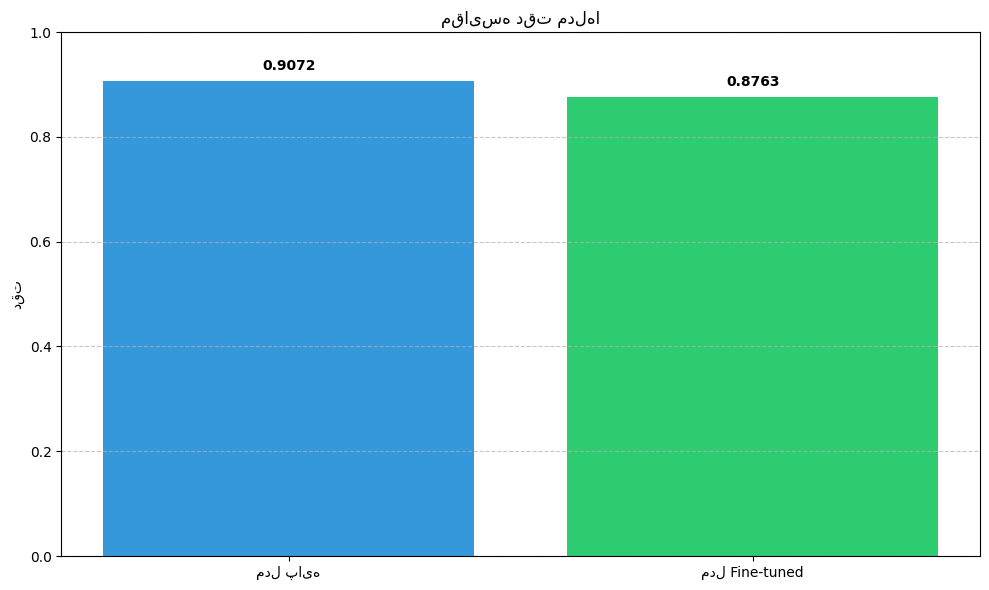

In [ ]:
print("بارگذاری مدل پایه...")
base_model, base_tokenizer = load_base_model()
print("بارگذاری مدل fine-tuned...")
ft_model, ft_tokenizer = load_finetuned_model(output_dir)

print("\nارزیابی مدل پایه:")
base_results, base_accuracy = evaluate_model(base_model, base_tokenizer, evaluation_data)

print("\nارزیابی مدل fine-tuned:")
ft_results, ft_accuracy = evaluate_model(ft_model, ft_tokenizer, evaluation_data)

with open('base_model_results.json', 'w', encoding='utf-8') as f:
    json.dump(base_results, f, ensure_ascii=False, indent=2)

with open('finetuned_model_results.json', 'w', encoding='utf-8') as f:
    json.dump(ft_results, f, ensure_ascii=False, indent=2)

print("\nمقایسه عملکرد مدل‌ها:")
print(f"مدل پایه (Llama-3.2-1B): {base_accuracy:.4f}")
print(f"مدل fine-tuned: {ft_accuracy:.4f}")
print(f"بهبود: {(ft_accuracy - base_accuracy) * 100:.2f}%")

plt.figure(figsize=(10, 6))
models = ['base model', ' Fine-tuned']
accuracies = [base_accuracy, ft_accuracy]
colors = ['#3498db', '#2ecc71']

plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1)
plt.title('accurecy of model')
plt.ylabel('accurecy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# تحلیل دسته‌بندی خطاها

In [59]:
def analyze_errors(results):
    errors = [r for r in results if not r['is_correct']]
    error_topics = {}
    for error in errors:
        question_lower = error['question'].lower()
        for keyword in ['علائم', 'تشخیص', 'درمان', 'عوارض', 'بیماری']:
            if keyword in question_lower:
                error_topics[keyword] = error_topics.get(keyword, 0) + 1

    return {
        'total_errors': len(errors),
        'error_rate': len(errors) / len(results),
        'error_topics': error_topics,
        'error_samples': errors[:5]
    }

In [60]:
base_error_analysis = analyze_errors(base_results)
ft_error_analysis = analyze_errors(ft_results)

print("\nتحلیل خطاهای مدل پایه:")
print(f"نرخ خطا: {base_error_analysis['error_rate']:.4f}")
print("دسته‌بندی خطاها بر اساس موضوع:")
for topic, count in base_error_analysis['error_topics'].items():
    print(f"- {topic}: {count}")

print("\nتحلیل خطاهای مدل fine-tuned:")
print(f"نرخ خطا: {ft_error_analysis['error_rate']:.4f}")
print("دسته‌بندی خطاها بر اساس موضوع:")
for topic, count in ft_error_analysis['error_topics'].items():
    print(f"- {topic}: {count}")

# خلاصه نتایج
results_summary = {
    'base_model': {
        'accuracy': base_accuracy,
        'error_rate': base_error_analysis['error_rate'],
        'error_topics': base_error_analysis['error_topics']
    },
    'finetuned_model': {
        'accuracy': ft_accuracy,
        'error_rate': ft_error_analysis['error_rate'],
        'error_topics': ft_error_analysis['error_topics']
    },
    'improvement': {
        'absolute': ft_accuracy - base_accuracy,
        'relative': (ft_accuracy - base_accuracy) / base_accuracy * 100 if base_accuracy > 0 else float('inf')
    }
}

# ذخیره خلاصه نتایج
with open('results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2)

print("\nخلاصه نتایج ذخیره شد.")


تحلیل خطاهای مدل پایه:
نرخ خطا: 0.0928
دسته‌بندی خطاها بر اساس موضوع:
- علائم: 2
- بیماری: 1
- درمان: 2

تحلیل خطاهای مدل fine-tuned:
نرخ خطا: 0.1237
دسته‌بندی خطاها بر اساس موضوع:
- علائم: 4
- بیماری: 1
- درمان: 2

خلاصه نتایج ذخیره شد.
